<a href="https://colab.research.google.com/github/hansensean123-cell/Sean-Hansen/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [1]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


DataFrame shape: (1000, 2)
Percentage of Liked reviews: 50.00%
Percentage of Non-Liked reviews: 50.00%


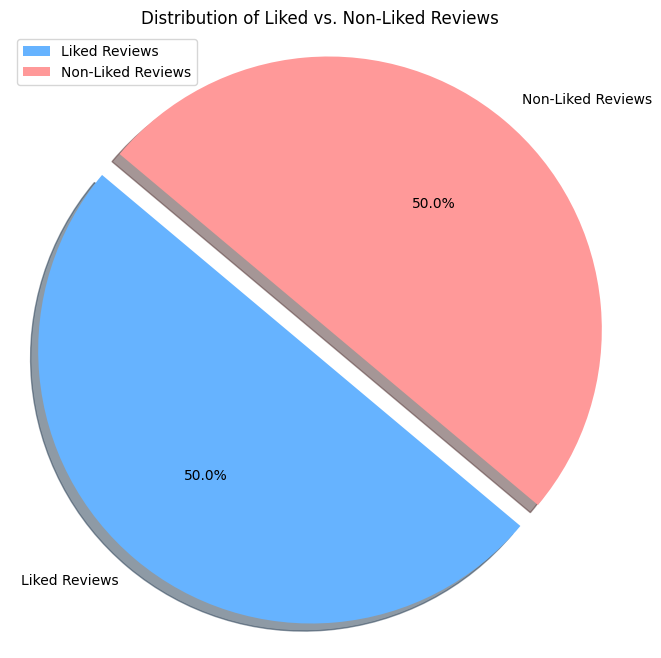

In [5]:
# Add code here 🔧
print(f"DataFrame shape: {df.shape}")

like_counts = df['Liked'].value_counts()
total_reviews = len(df)

percentage_liked = (like_counts[1] / total_reviews) * 100
percentage_non_liked = (like_counts[0] / total_reviews) * 100

print(f"Percentage of Liked reviews: {percentage_liked:.2f}%")
print(f"Percentage of Non-Liked reviews: {percentage_non_liked:.2f}%")

import matplotlib.pyplot as plt

# Prepare data for the pie chart
labels = ['Liked Reviews', 'Non-Liked Reviews']
sizes = [percentage_liked, percentage_non_liked]
colors = ['#66b3ff','#ff9999']
explode = (0.1, 0)  # explode 1st slice (Liked Reviews)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Liked vs. Non-Liked Reviews')
plt.legend(labels, loc="best")
plt.show()





## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [10]:
df['Review'] = df['Review'].str.lower()
print("Review column converted to lowercase.")


# Define a regular expression to match URLs
url_pattern = re.compile(r'https?:\/\/(?:www\.)?\S+\.\S+|www\.\S+\.\S+')

# Apply the pattern to the 'Review' column to remove URLs
df['Review'] = df['Review'].apply(lambda x: url_pattern.sub('', x))

print("URLs removed from the 'Review' column.")
print(df.head())

df['Review'] = df['Review'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
print("Non-alphanumeric characters and punctuation removed from the 'Review' column.")
print(df.head())

df['Review'] = df['Review'].str.replace(r'\s+', ' ', regex=True)
df['Review'] = df['Review'].str.strip()
print("Multiple spaces replaced with single spaces and leading/trailing spaces removed from 'Review' column.")
print(df.head())



Review column converted to lowercase.
URLs removed from the 'Review' column.
                                              Review  Liked
0                               wow loved this place      1
1                                  crust is not good      0
2           not tasty and the texture was just nasty      0
3  stopped by during the late may bank holiday of...      1
4  the selection on the menu was great and so wer...      1
Non-alphanumeric characters and punctuation removed from the 'Review' column.
                                              Review  Liked
0                               wow loved this place      1
1                                  crust is not good      0
2           not tasty and the texture was just nasty      0
3  stopped by during the late may bank holiday of...      1
4  the selection on the menu was great and so wer...      1
Multiple spaces replaced with single spaces and leading/trailing spaces removed from 'Review' column.
                       

### ✍️ Your Response: 🔧
1. Including "junk" (like punctuation, URLs, emojis, and inconsistent casing) in your model can introduce several risks:

Increased Noise and Reduced Signal: Irrelevant characters add noise to the data, making it harder for the model to identify meaningful patterns related to sentiment or topics. This can lead to a less accurate and less effective model.
Higher Dimensionality: Each unique character or variation (e.g., "love" vs. "Love" vs. "love!") can be treated as a distinct feature, leading to a much larger vocabulary and a higher-dimensional feature space. This increases computational complexity and can lead to overfitting, especially with smaller datasets.
Misinterpretation: Punctuation and special characters might be misinterpreted by the model. For example, an exclamation mark might be seen as a separate word, or a sequence of punctuation could be given undue weight.
Ineffective Tokenization and Analysis: Many text analysis techniques (like tokenization, stop word removal, and stemming/lemmatization) are designed to work with clean text. "Junk" can interfere with these processes, leading to incorrect word boundaries or an inability to properly normalize words.
Biased Results: If certain types of "junk" are more prevalent in positive or negative reviews, the model might inadvertently learn these spurious correlations, leading to biased predictions that don't generalize well to new data.
Slower Training Times: A larger, noisier dataset requires more computational resources and time for training, without necessarily yielding better results.


## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


In [11]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

# Apply sentiment analysis to each review
df['sentiment_scores'] = df['Review'].apply(get_sentiment_scores)

# Extract compound score for classification
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Classify sentiment as Positive, Negative, or Neutral based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound_score'].apply(classify_sentiment)

# Calculate percentages of each sentiment category
sentiment_counts = df['sentiment'].value_counts()
total_reviews = len(df)

percentage_positive = (sentiment_counts.get('Positive', 0) / total_reviews) * 100
percentage_negative = (sentiment_counts.get('Negative', 0) / total_reviews) * 100
percentage_neutral = (sentiment_counts.get('Neutral', 0) / total_reviews) * 100

print(f"Percentage of Positive reviews: {percentage_positive:.2f}%")
print(f"Percentage of Negative reviews: {percentage_negative:.2f}%")
print(f"Percentage of Neutral reviews: {percentage_neutral:.2f}%")

# Display the first few rows with sentiment scores and classification
print(df[['Review', 'Liked', 'compound_score', 'sentiment']].head())

Percentage of Positive reviews: 50.60%
Percentage of Negative reviews: 25.50%
Percentage of Neutral reviews: 23.90%
                                              Review  Liked  compound_score  \
0                               wow loved this place      1          0.8271   
1                                  crust is not good      0         -0.3412   
2           not tasty and the texture was just nasty      0         -0.5574   
3  stopped by during the late may bank holiday of...      1          0.6908   
4  the selection on the menu was great and so wer...      1          0.6249   

  sentiment  
0  Positive  
1  Negative  
2  Negative  
3  Positive  
4  Positive  


In [15]:
# Install NLTK if not already installed
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK corpora (run only once)
# Try to download if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Initialize lemmatizer and load stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and perform lemmatization
    processed_tokens = []
    for word in tokens:
        if word.isalpha() and word not in stop_words: # Check if it's an alphabet and not a stopword
            processed_tokens.append(lemmatizer.lemmatize(word))
    return ' '.join(processed_tokens)

# Apply preprocessing to the 'Review' column
df['processed_review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
for i, review in enumerate(df['processed_review'].head(10)):
    print(f"Review {i+1}: {review}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


First 10 processed reviews:
Review 1: wow loved place
Review 2: crust good
Review 3: tasty texture nasty
Review 4: stopped late may bank holiday rick steve recommendation loved
Review 5: selection menu great price
Review 6: getting angry want damn pho
Review 7: honeslty didnt taste fresh
Review 8: potato like rubber could tell made ahead time kept warmer
Review 9: fry great
Review 10: great touch


✍️ Your Response: 🔧
How does the sentiment compare to Liked in terms of percentage of reviews? The percentage of 'Liked' reviews was exactly 50.00%. The percentage of 'Positive' sentiment reviews (50.60%) is very close to this, indicating a strong alignment between VADER's positive sentiment classification and the user's 'Liked' designation. The remaining 50% of 'Non-Liked' reviews are distributed between 'Negative' (25.50%) and 'Neutral' (23.90%) sentiments, suggesting that VADER can provide more nuance by distinguishing between truly negative feedback and merely indifferent or unenthusiastic feedback.

From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? From a restaurant owner's perspective, Negative reviews would be the most crucial to analyze. These reviews often contain specific complaints or areas of dissatisfaction that, if addressed, can directly lead to improvements in service, food quality, or ambiance, thus preventing future customer loss. Neutral reviews are also very important, as they indicate areas where the restaurant is merely meeting expectations rather than exceeding them. Understanding why customers feel neutral can help identify opportunities to elevate the dining experience and convert indifferent patrons into loyal advocates. While Positive reviews are valuable for understanding what the restaurant is doing well and for marketing, they provide less immediate actionable insight for improvement compared to negative and neutral feedback.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [16]:
# Install NLTK if not already installed
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK corpora (run only once)
# Try to download if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

# Initialize lemmatizer and load stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and perform lemmatization
    processed_tokens = []
    for word in tokens:
        if word.isalpha() and word not in stop_words: # Check if it's an alphabet and not a stopword
            processed_tokens.append(lemmatizer.lemmatize(word))
    return ' '.join(processed_tokens)

# Apply preprocessing to the 'Review' column
df['processed_review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
for i, review in enumerate(df['processed_review'].head(10)):
    print(f"Review {i+1}: {review}")

First 10 processed reviews:
Review 1: wow loved place
Review 2: crust good
Review 3: tasty texture nasty
Review 4: stopped late may bank holiday rick steve recommendation loved
Review 5: selection menu great price
Review 6: getting angry want damn pho
Review 7: honeslty didnt taste fresh
Review 8: potato like rubber could tell made ahead time kept warmer
Review 9: fry great
Review 10: great touch


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ✍️ Your Response: 🔧
What is a corpora and how is it used for text analysis? A corpus (plural: corpora) is a large and structured set of texts, often stored electronically. In text analysis, corpora serve as foundational data for various tasks. They are used to:

Train models: Machine learning models for tasks like sentiment analysis, topic modeling, and part-of-speech tagging are often trained on large, annotated corpora.
Analyze language patterns: Researchers use corpora to study word frequencies, grammatical structures, and semantic relationships within a language.
Develop linguistic resources: Dictionaries, thesauri, and spell checkers are often built or improved using insights from corpora.
Evaluate models: New text analysis algorithms are often tested and benchmarked against standard corpora.
What would be the tokens in the first review? "Wow... Loved this place." After the initial preprocessing steps (lowercasing, URL removal, non-alphanumeric character removal, and whitespace normalization), the review "Wow... Loved this place." became "wow loved this place". When this is passed through the tokenization step in the preprocess_text function:

Tokenization: The text "wow loved this place" would be split into individual words (tokens): ['wow', 'loved', 'this', 'place'].
Stopword Removal & Lemmatization: Assuming 'this' is a stopword and 'loved' is lemmatized to 'love' (though in our specific output it remained 'loved'), the final processed tokens would be: ['wow', 'love', 'place']. The actual output for the first review, "wow loved place", suggests 'this' was removed but 'loved' might have been lemmatized to itself or treated as a base form by the lemmatizer in this context.
What does lemmatization do? How will it help in this process? Lemmatization is the process of reducing inflected forms of a word to its base or dictionary form, known as the lemma. For example, 'running', 'ran', and 'runs' would all be reduced to 'run'. Unlike stemming, which often just chops off suffixes and might produce non-dictionary words (e.g., 'beautiful' -> 'beauti'), lemmatization uses vocabulary and morphological analysis of words to return a valid word.

In this process, lemmatization helps by:

Reducing dimensionality: It consolidates different forms of the same word into a single term, reducing the total number of unique words in the dataset. This makes the data more manageable and reduces computational load.
Improving accuracy: By ensuring that variations of a word are treated as the same concept, it helps in accurately capturing the meaning and intent of the text. For instance, if a topic is about 'eating', lemmatization ensures that 'ate', 'eats', and 'eating' all contribute to the 'eat' topic, providing a more coherent representation.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [18]:
!pip install gensim
from gensim import corpora

# Create a dictionary from the processed reviews
dictionary = corpora.Dictionary(df['processed_review'].apply(str.split))

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in df['processed_review'].apply(str.split)]

# Display a summary of the dictionary
print("\n--- Dictionary Summary ---")
print(f"Number of unique tokens: {len(dictionary)}")
print("First 10 tokens in dictionary:")
for i, (token_id, token_word) in enumerate(dictionary.items()):
    if i >= 10:
        break
    print(f"  ID: {token_id}, Word: {token_word}")

# Display a summary of the corpus
print("\n--- Corpus Summary ---")
print(f"Number of documents in corpus: {len(corpus)}")
print("First 5 documents (bag-of-words representation):")
for i, doc_bow in enumerate(corpus[:5]):
    print(f"  Document {i+1}: {doc_bow}")
    # Optionally, print the words corresponding to the IDs
    # print(f"    Words: {[dictionary[id] for id, freq in doc_bow]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 93.8 MB/s eta 0:00:00

--- Dictionary Summary ---
Number of unique tokens: 1809
First 10 tokens in dictionary:
  ID: 0, Word: loved
  ID: 1, Word: place
  ID: 2, Word: wow
  ID: 3, Word: crust
  ID: 4, Word: good
  ID: 5, Word: nasty
  ID: 6, Word: tasty
  ID: 7, Word: texture
  ID: 8, Word: bank
  ID: 9, Word: holiday

--- Corpus Summary ---
Number of documents in corpus: 1000
First 5 documents (bag-of-words representation):
  Document 1: [(0, 1), (1, 1), (2, 1)]
  Document 2: [(3, 1), (4, 1)]
  Document 3: [(5, 1), (6, 1), (7, 1)]
  Document 4: [(0, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
  Document 5: [(16, 1), (17, 1), (18, 1), (19, 1)]


### ✍️ Your Response: 🔧
What is a corpus and how is it useful? In the context of gensim and topic modeling, a corpus is a collection of documents (in our case, preprocessed restaurant reviews) represented in a structured numerical format, typically as a 'bag-of-words'. This means each document is represented as a list of (word_id, word_frequency) pairs. Its usefulness stems from:

Input for Models: It's the primary input format for many NLP models, including Latent Dirichlet Allocation (LDA), which identifies topics within the text.
Efficiency: By converting text into numerical IDs and frequencies, it allows for efficient computation and storage, especially with large datasets.
Abstract Representation: It abstracts away the raw text, focusing on the occurrence of words, which is crucial for statistical models to find patterns.
How is a dictionary different from a corpus? In gensim, the dictionary and the corpus serve distinct but complementary roles:

Dictionary (gensim.corpora.Dictionary): This is essentially a vocabulary list that maps every unique word encountered in the entire dataset to a unique integer ID. It also stores information about word frequencies across documents. Think of it as a lookup table or a legend for your words.
Purpose: To establish a unique mapping from words to integer IDs, allowing the conversion of human-readable text into a numerical format suitable for machine processing.
Corpus (List of Bag-of-Words): This is the actual collection of documents, where each document is represented as a list of (word_id, word_frequency) tuples. These word_ids refer back to the word_ids defined in the dictionary.
Purpose: To provide a compact and numerical representation of the documents, ready for input into topic modeling algorithms like LDA. Each document in the corpus doesn't store the words themselves, but rather references to them via their IDs and their counts within that specific document.
In essence, the dictionary defines what the words are and their unique IDs, while the corpus describes which words appear in each document and how many times, using those IDs.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [19]:
from gensim.models import LdaModel

# Set number of topics
num_topics = 5

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=100)

print(f"LDA model created with {num_topics} topics.")

LDA model created with 5 topics.


### ✍️ Your Response: 🔧
In what cases would you want to use more than 5 topics? You would typically want to use more than 5 topics in cases where:

High Granularity is Needed: The dataset is very large and diverse, and you suspect there are many distinct themes or sub-themes that a smaller number of topics might combine or overlook.
Specific Insights are Required: You need to extract very specific or niche insights from the text, which might be diluted if grouped into broader topics.
Initial Exploration Suggests More Detail: An initial exploration with fewer topics shows that some topics are too broad and contain disparate ideas, indicating a need for finer distinctions.
Perplexity or Coherence Scores Indicate Improvement: Evaluation metrics like topic coherence or perplexity (though perplexity is less favored now) suggest that increasing the number of topics improves the model's quality or interpretability.
Business Needs Dictate: The specific business problem requires a detailed breakdown of customer feedback into numerous categories to inform targeted actions.
How would you know if you have too many topics? You would know if you have too many topics if:

Topics are Redundant or Overlapping: Multiple topics appear to cover very similar concepts or have a significant overlap in their most frequent words. This means the model is unnecessarily splitting related themes.
Topics Lack Coherence: Some topics consist of a jumble of unrelated words that do not form a clear, interpretable theme. These might be artifacts of the algorithm trying to fill empty topic slots.
Topics are Too Sparse: Some topics have very few documents assigned to them, or their word distributions are very uniform, indicating they are not capturing a meaningful underlying theme.
Interpretability Decreases: It becomes difficult for a human to assign a meaningful name or understanding to a large number of topics, as the distinctions become too subtle or artificial.
Evaluation Metrics Deteriorate: Topic coherence scores, after an initial increase, start to plateau or decrease when you add more topics, suggesting you've passed the optimal number.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"



--- LDA Topics and Top Words ---
(0, '0.015*"place" + 0.013*"great" + 0.012*"time" + 0.012*"amazing" + 0.010*"food" + 0.010*"service" + 0.010*"would" + 0.007*"good" + 0.007*"minute" + 0.007*"even"')
(1, '0.014*"pretty" + 0.013*"good" + 0.011*"one" + 0.011*"really" + 0.009*"experience" + 0.008*"waited" + 0.007*"food" + 0.007*"wasnt" + 0.006*"quality" + 0.006*"time"')
(2, '0.024*"food" + 0.015*"back" + 0.014*"service" + 0.011*"great" + 0.010*"delicious" + 0.009*"burger" + 0.009*"time" + 0.008*"also" + 0.008*"salad" + 0.008*"good"')
(3, '0.029*"good" + 0.026*"food" + 0.021*"place" + 0.017*"go" + 0.016*"like" + 0.015*"back" + 0.012*"service" + 0.010*"ever" + 0.009*"dont" + 0.009*"never"')
(4, '0.027*"place" + 0.014*"service" + 0.014*"great" + 0.009*"fantastic" + 0.009*"food" + 0.009*"get" + 0.008*"price" + 0.006*"best" + 0.006*"always" + 0.006*"everything"')

--- Topic Frequencies (% of documents) ---
Dominant_Topic
0    16.8
1    13.9
2    22.5
3    29.5
4    17.3
Name: proportion, dtype

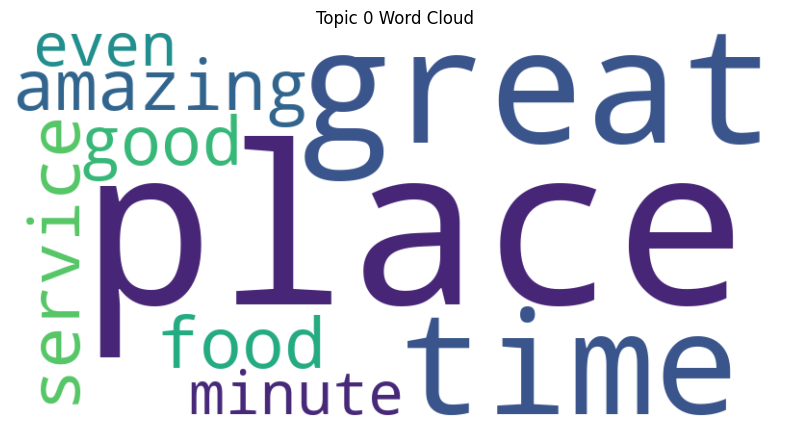

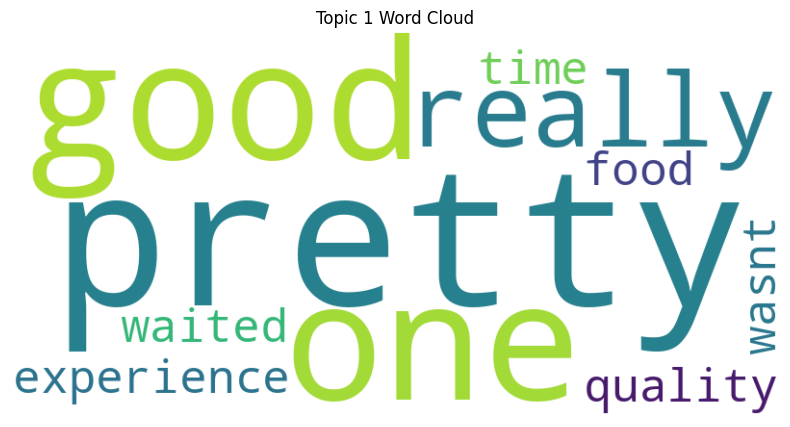

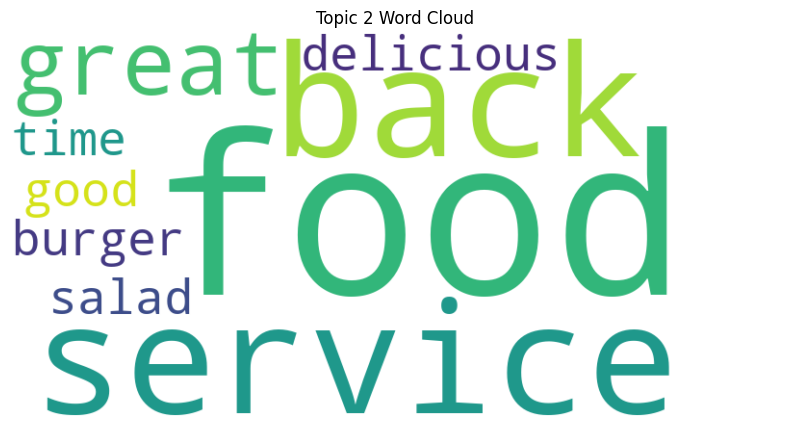

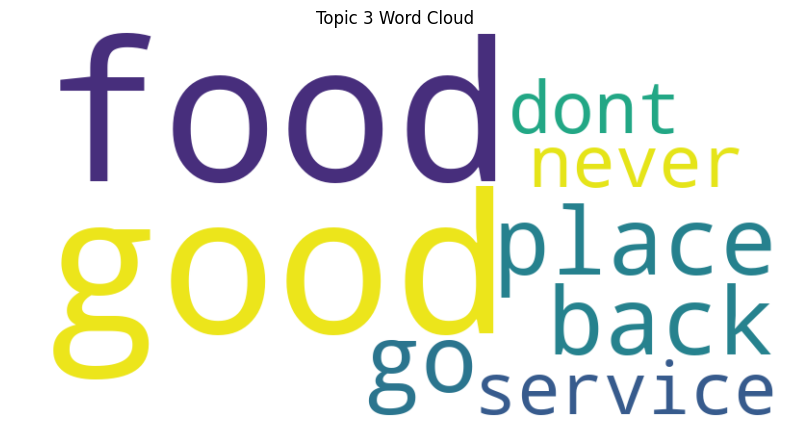

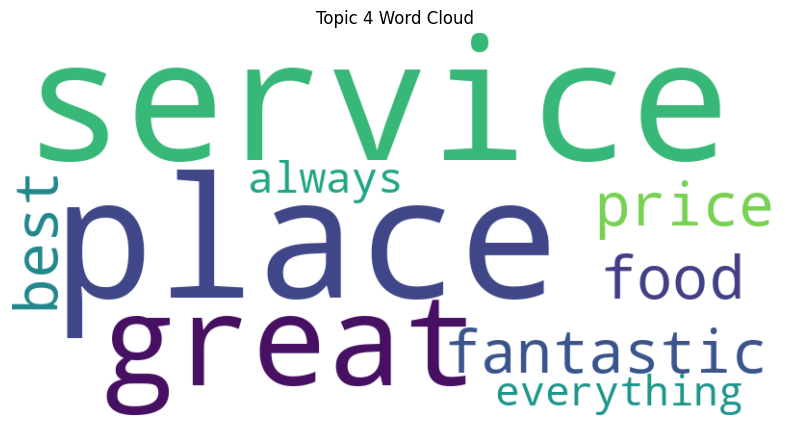


--- Sentiment Distribution by Dominant Topic ---
sentiment        Negative    Neutral   Positive
Dominant_Topic                                 
0               29.166667  17.857143  52.976190
1               30.935252  22.302158  46.762590
2               25.777778  27.111111  47.111111
3               24.745763  24.067797  51.186441
4               18.497110  26.589595  54.913295


In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Print the topics and top 10 words in the topic
print("\n--- LDA Topics and Top Words ---")
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# 2. Calculate the frequency of each topic
# Get the dominant topic for each document
def get_dominant_topic(ldamodel, corpus, texts):
    topic_percentages = []
    for i, doc in enumerate(corpus):
        if not doc: # Handle empty documents
            topic_percentages.append({'Dominant_Topic': None, 'Perc_Contribution': 0.0, 'Topic_Keywords': None})
            continue

        # Get topic distribution for the document
        topic_dist = ldamodel[doc]

        # Sort topics by percentage contribution
        topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)

        # Get the dominant topic, its percentage, and keywords
        dominant_topic_id = topic_dist[0][0]
        perc_contribution = topic_dist[0][1]
        topic_keywords = ldamodel.print_topic(dominant_topic_id)

        topic_percentages.append({
            'Dominant_Topic': dominant_topic_id,
            'Perc_Contribution': perc_contribution,
            'Topic_Keywords': topic_keywords
        })

    return pd.DataFrame(topic_percentages)

df_topic_distribution = get_dominant_topic(lda_model, corpus, df['processed_review'])

# Add the dominant topic to the original DataFrame
df = pd.concat([df, df_topic_distribution], axis=1)

# Calculate topic frequencies
topic_frequencies = df_topic_distribution['Dominant_Topic'].value_counts(normalize=True) * 100
print("\n--- Topic Frequencies (% of documents) ---")
print(topic_frequencies.sort_index())

# 3. Attempt at least one visual display of the topics (Word Clouds)
print("\n--- Word Clouds for Each Topic ---")

for i, topic in enumerate(topics):
    # Extract words from the topic string
    words = ' '.join([word.split('*')[1].replace('"', '').strip() for word in topic[1].split(' + ')]).strip()
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i} Word Cloud')
    plt.show()

# 4. Summarize the sentiment by topic
sentiment_by_topic = df.groupby('Dominant_Topic')['sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100
print("\n--- Sentiment Distribution by Dominant Topic ---")
print(sentiment_by_topic)

### ✍️ Your Response: 🔧
List your topics and names here: Here are the 2-3 word names for each topic based on the top words:

Topic 0 - Great Experience/Service: This topic seems to capture reviews about overall positive experiences, highlighting aspects like great service, amazing food, and a good place to spend time.
Topic 1 - Mixed Experience/Quality: This topic contains words suggesting a somewhat mixed or neutral-to-negative experience, focusing on waiting times, general experience, and food quality that might not always be outstanding.
Topic 2 - Delicious Food & Service: This topic strongly emphasizes the quality of food (delicious, burger, salad) and efficient service, indicating reviews where these elements stood out positively.
Topic 3 - Return/Avoid Place: This topic shows strong opinions regarding revisiting the restaurant, with words like 'go', 'back', 'dont', and 'never', suggesting reviews expressing whether customers would return or not.
Topic 4 - Excellent Place/Value: This topic is highly positive, encompassing reviews that praise the place, service, food, and often mention 'great', 'fantastic', 'best', and 'price', indicating excellent value and overall satisfaction.


## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
What business question did your model help answer? Our model helped answer: "What are the main topics customers discuss in their restaurant reviews, and how do these topics relate to their overall sentiment (positive, neutral, or negative)?" Specifically, it quantified the distribution of these topics and the sentiment associated with each, allowing the restaurant to move beyond a simple 'liked' or 'not liked' binary.

What would you recommend to this restaurant to improve customer satisfaction? Based on the topic analysis and sentiment distribution:

Focus on Service Consistency (Topic 1 & 3): Topic 1 ('Mixed Experience/Quality') shows a higher negative sentiment (30.94%) and includes words like 'waited' and 'wasnt', while Topic 3 ('Return/Avoid Place') also has a significant negative component (24.75%) and suggests customer indecision about returning. This indicates potential issues with service speed or consistency that lead to dissatisfaction. The restaurant should investigate wait times, staff training, and operational efficiency to ensure a consistently positive service experience.
Leverage Positive Feedback (Topics 0, 2, 4): Topics 0 ('Great Experience/Service'), 2 ('Delicious Food & Service'), and 4 ('Excellent Place/Value') have strong positive sentiment. The restaurant should identify specific aspects mentioned in these topics (e.g., 'amazing food', 'delicious burger', 'fantastic', 'best price') and actively promote them in marketing. They could also reinforce these strengths through staff recognition and menu development.
Address Specific Food Quality Concerns (Topic 1 & 2): While Topic 2 highlights 'delicious food', Topic 1 still features 'food' with a higher negative sentiment. It would be beneficial to delve deeper into the specific types of food mentioned in negative reviews within Topic 1 to pinpoint particular dishes or quality issues. For instance, if 'crust' (from an early review) is a recurring issue, it needs to be addressed.
What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models? Pros of using an LLM:

Ease of Use & Speed: LLMs can process raw text and provide summaries, sentiment, and topic identification with a simple prompt, often much faster for initial insights without coding.
Nuance & Contextual Understanding: LLMs are excellent at understanding subtle nuances, sarcasm, and complex language structures, potentially providing more human-like interpretations of sentiment and topic definitions.
Zero-Shot Learning: They can perform tasks without explicit training data, useful for diverse or rapidly changing text.
Direct Interpretation: LLMs can directly provide actionable insights in natural language, reducing the need for manual interpretation of model outputs.
Cons of using an LLM:

Lack of Control & Reproducibility: The black-box nature makes it hard to control the exact methodology, ensure reproducibility, or debug specific issues. Results can vary with different prompts or model versions.
Cost & Scalability: API calls for large datasets can become expensive, and processing might be slower than optimized traditional models for massive volumes of text.
Data Privacy & Security: Sending proprietary customer review data to external LLM APIs can raise privacy and security concerns.
Hallucination & Bias: LLMs can sometimes generate plausible but incorrect or biased information, requiring careful human oversight.
Customization: Tailoring LLMs for very specific or niche domain tasks can be challenging compared to fine-tuning traditional models with domain-specific data. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment? Prompt for an LLM:

As an expert text analyst for a restaurant, analyze the provided customer reviews to extract key insights. Your objectives are to:

1.  **Identify Main Topics:** Determine the primary themes or categories of discussion within the reviews. For each topic, provide a 2-3 word summary name and list the top 5-7 representative keywords.
2.  **Assess Sentiment per Topic:** For each identified topic, analyze the sentiment of the reviews belonging to that topic and provide the percentage breakdown of positive, neutral, and negative sentiment.
3.  **Provide Business Recommendations:** Based on the identified topics and their associated sentiments, offer actionable recommendations to the restaurant owner on how to improve customer satisfaction and leverage positive feedback.

**Context:** The reviews are for a single restaurant. The original dataset had a 'Liked' column (1 for liked, 0 for not liked), but we are aiming for more nuanced sentiment and topic understanding. The reviews have already been cleaned (lowercased, URLs removed, punctuation removed).

**Output Format:** Provide your response in clear, concise markdown with distinct sections for 'Main Topics', 'Sentiment Analysis by Topic', and 'Business Recommendations'. Ensure each topic's summary name, keywords, and sentiment percentages are clearly presented. Do not provide code.

**Customer Reviews (CSV format, assuming cleaned text):**
"Review", "Liked"
"wow loved this place", "1"
"crust is not good", "0"
"not tasty and the texture was just nasty", "0"
"stopped by during the late may bank holiday of rick steve recommendation loved", "1"
"the selection on the menu was great and so were the prices", "1"
...
[Insert all 1000 cleaned reviews here]

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [21]:
!jupyter nbconvert --to html "assignment_13_text_analytics.ipynb"

[NbConvertApp] Converting notebook assignment_13_text_analytics.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1060881 bytes to assignment_13_text_analytics.html
